In [ ]:
import numpy as np
import cv2
from scipy.constants import c, pi
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
from scipy.ndimage import gaussian_filter1d, shift
from tqdm import tqdm

%cd ".."
import simulation as sim
import fft_shift as fft_shift
from utils import compute_I_analytical, calculate_snr

from fig_setup import fig_setup

fig_setup()

#### Useful parameters

In [2]:
# data paths and variables
save_figs = False

mod_freq = 60 # MHz
wavelength = 940 # nm
k = np.deg2rad(90)
calib_offset = 624.5 # mm
cropX = 0
cropY = 0

# from mlx datasheet
unambig_dist = (c*0.5)/(mod_freq *1e6)
coeff_to_rad = unambig_dist / (2 * pi)

#### Load the data

(480, 640)


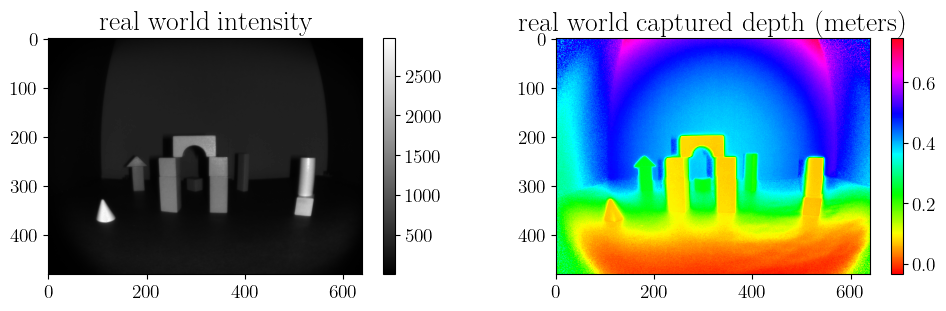

In [3]:
with np.load('data/emulation/dist_amp.npz') as gt_data:
    depth_rw = ((gt_data['dist'] - calib_offset) * 1e-3)[cropY:, cropX:] # divide by 1e3 to get meters
    intensity_rw = gt_data['amp'][cropY:, cropX:]
    
with np.load('data/emulation/phase_data.npz') as phase_data:
    I0_rw = phase_data['phase0'][cropY:, cropX:]
    I90_rw = phase_data['phase90'][cropY:, cropX:]
    I180_rw = phase_data['phase180'][cropY:, cropX:]
    I270_rw = phase_data['phase270'][cropY:, cropX:]
    
phase_rw = (depth_rw / coeff_to_rad) - pi # calculate the phase from the depth

quad_data_rw = [I0_rw, I90_rw, I180_rw, I270_rw]

# show the real world data
fig_rw, axs = plt.subplots(1,2, figsize=(10,3), layout="constrained")
im = axs[0].imshow(intensity_rw, cmap="gray")
axs[0].set_title("real world intensity")
fig_rw.colorbar(im, ax=axs[0])


im = axs[1].imshow(depth_rw, cmap="hsv")
axs[1].set_title("real world captured depth (meters)")
fig_rw.colorbar(im, ax=axs[1])

print(intensity_rw.shape)

## Apply normal distribution to theta

In [4]:
np.random.seed(100)
num_trials = 25
num_std_devs = 20
std_devs_d = np.linspace(0.0, 2.0, num=num_std_devs)
std_devs = np.deg2rad(std_devs_d)
snrs_intensity = []
snrs_phase = []
data_recon_phase = np.zeros((std_devs.shape[0], num_trials, intensity_rw.shape[0], intensity_rw.shape[1]))

thetas = np.empty((num_trials, num_std_devs, intensity_rw.shape[0], intensity_rw.shape[1]))

for i in tqdm(range(std_devs.shape[0])):
    std_dev = std_devs[i]
    cur_snr_intensity = np.zeros(num_trials)
    cur_snr_phase = np.zeros(num_trials)
    for j in range(num_trials):
        
        A = intensity_rw
        w= 2 * pi * (mod_freq * 1e6)
        phase_rw = (2 * depth_rw * w )/ c
    
        # create the nonlinear theta
        tmp_x = np.arange(0, A.shape[1])
        tmp_y = (k * np.linspace(0, A.shape[0] - 1, num=A.shape[0])) + np.random.default_rng().normal(0, std_dev, size=(A.shape[0]))

        _, theta = np.meshgrid(tmp_x, tmp_y)  # theta(x) = kx, this is the illumination varied by x
        thetas[j,i,:,:] = theta

        # Kill overlapping high frequency from ground truth intensity
        filter_axis = 0 # horizontal stripes
        F_tmp = gaussian_filter1d(A*(np.cos(phase_rw) + 1j*np.sin(phase_rw)), 1, axis=filter_axis, mode='constant')
        A = abs(F_tmp)
        phi = np.angle(F_tmp)

        composite_image = compute_I_analytical(A, theta, phi,'mlx')
        F_filtered = np.fft.fftshift(np.fft.fft2(composite_image))
    
        # calculate the fft shift
        comp_img_32 = np.float32(composite_image) # make sure image is float 32

        fft = np.fft.fftshift(np.fft.fft2(comp_img_32))  # Fourier transform of the composite image
        height, width = comp_img_32.shape

        fft_centered = np.zeros(fft.shape,  dtype=np.complex128)

        # Center the Fourier 
        shift_by = (k / pi) * (height / 2.0)
        fft_centered = shift(fft, (height/2.0, 0))
        fft_centered = shift(fft_centered, (-(height/2.0) + shift_by,0))
        fft_centered[:int(height/2 - shift_by/1.1),:] = 0
        fft_centered[int(height/2 + shift_by/1.1):,:] = 0

        fft_reverse = np.fft.ifft2(np.fft.ifftshift(fft_centered))

        recon_intensity = np.abs(fft_reverse) * 2.0
        recon_phase = -np.angle(fft_reverse) - pi/2.0

        data_recon_phase[i, j] = recon_phase

        cur_snr_intensity[j] = calculate_snr(intensity_rw, recon_intensity*2)
        cur_snr_phase[j] = calculate_snr(phase_rw - pi, recon_phase)

    snrs_intensity.append(cur_snr_intensity)
    snrs_phase.append(cur_snr_phase)

100%|███████████████████████████████████████████| 20/20 [01:06<00:00,  3.30s/it]


#### Visualize the SNR

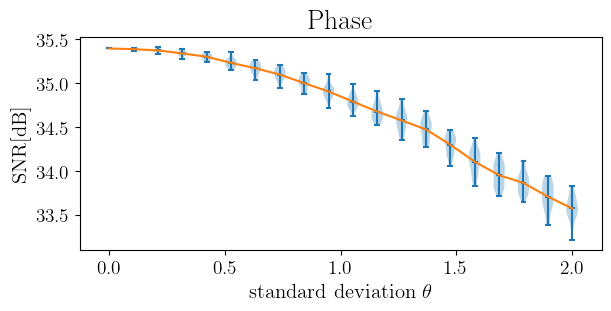

In [5]:
fig, ax = plt.subplots(1,1, figsize=(6,3), layout="constrained")

ax.violinplot(dataset=snrs_phase, positions=std_devs_d, widths=0.05, showmeans=True, points=25)
ax.plot(std_devs_d, np.mean(snrs_phase, axis=1))

ax.set_title("Phase")
ax.set_xlabel("standard deviation $\\theta$")
ax.set_ylabel("SNR[dB]")

if save_figs:
    fig.savefig("figures/CVPRfigures/nonlinear_phase_shift.pdf", bbox_inches = 'tight')

#### Visualize qualitative results

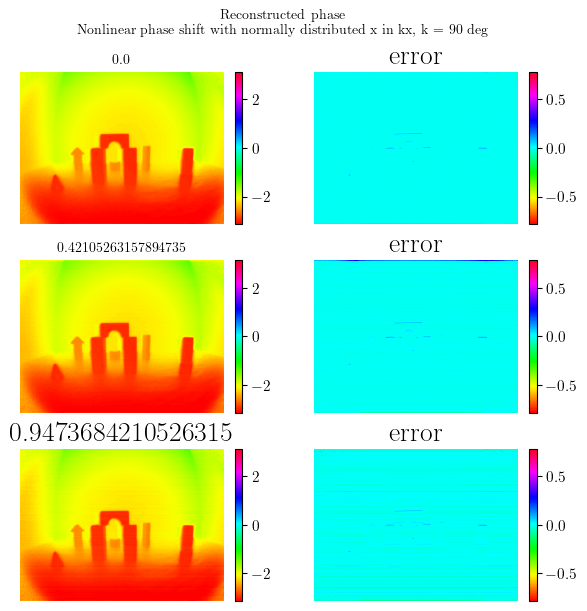

In [6]:
fig, ax = plt.subplots(3,2, figsize=(6,6), layout="constrained")
fig.suptitle("Reconstructed phase\nNonlinear phase shift with normally distributed x in kx, k = {} deg".format(90), size=10)

img = ax[0,0].imshow(data_recon_phase[0, 10], cmap="hsv", vmin=-pi, vmax=pi)
cbar=fig.colorbar(img)
cbar.ax.tick_params(labelsize=11) 
ax[0,0].axis('off')
ax[0,0].set_title(str(std_devs_d[0]), size=10)
img = ax[0,1].imshow(phase_rw - pi - data_recon_phase[0, 10], cmap="hsv", vmin=-pi/4, vmax=pi/4)
cbar=fig.colorbar(img)
cbar.ax.tick_params(labelsize=11) 
ax[0,1].axis('off')
ax[0,1].set_title("error")

img=ax[1,0].imshow(data_recon_phase[4, 10], cmap="hsv", vmin=-pi, vmax=pi)
ax[1,0].axis('off')
cbar=fig.colorbar(img)
cbar.ax.tick_params(labelsize=11) 
ax[1,0].set_title(str(std_devs_d[4]), size=10)
img=ax[1,1].imshow(phase_rw - pi - data_recon_phase[4, 10], cmap="hsv", vmin=-pi/4, vmax=pi/4)
ax[1,1].axis('off')
cbar=fig.colorbar(img)
cbar.ax.tick_params(labelsize=11) 
ax[1,1].set_title("error")

img=ax[2,0].imshow(data_recon_phase[9, 10], cmap="hsv", vmin=-pi, vmax=pi)
ax[2,0].axis('off')
cbar=fig.colorbar(img)
cbar.ax.tick_params(labelsize=11) 
ax[2,0].set_title(str(std_devs_d[9]))
img=ax[2,1].imshow(phase_rw - pi - data_recon_phase[9, 10], cmap="hsv", vmin=-pi/4, vmax=pi/4)
ax[2,1].axis('off')
cbar=fig.colorbar(img)
cbar.ax.tick_params(labelsize=11) 
ax[2,1].set_title("error")

if save_figs:
    fig.savefig("figures/CVPRfigures/nonlinear_phase_shift_qual.pdf", bbox_inches = 'tight')